In [5]:
import lmdb
import os
import torch
import random
import skimage
import numpy as np
import torch.nn as nn
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

print("complete")

complete


In [6]:
train_vectors = np.load("object_bird_train.npy")
test_vectors = np.load("object_bird_test.npy")

reverse_transform = transforms.Compose([
                transforms.Normalize([0,  0,  0], [1/0.229,1/0.225,1/0.263]),
                transforms.Normalize([-0.486,-0.499,-0.432], [1,  1,  1]),
                transforms.ToPILImage(),
            ])

data_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(224),
                transforms.RandomCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.486,0.499,0.432], [0.229,0.225,0.263])
            ])

root_dir = '/home/lvlab/Pytorch/images'
train_file = '/home/lvlab/Pytorch/train.txt'
f = open(train_file, 'r')
train_list = f.readlines()
f.close()

3
N =  73


/home/lvlab/.tensorflow_pytorch/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/lvlab/.tensorflow_pytorch/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/lvlab/.tensorflow_pytorch/lib/python3.5/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


1003
N =  39
2003
N =  117
3003
N =  144
4003
N =  121
5003
N =  83
complete


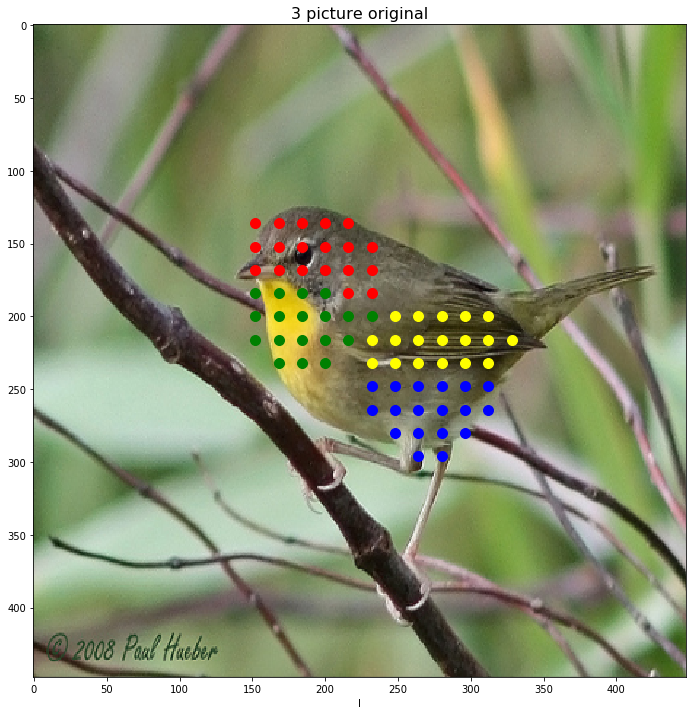

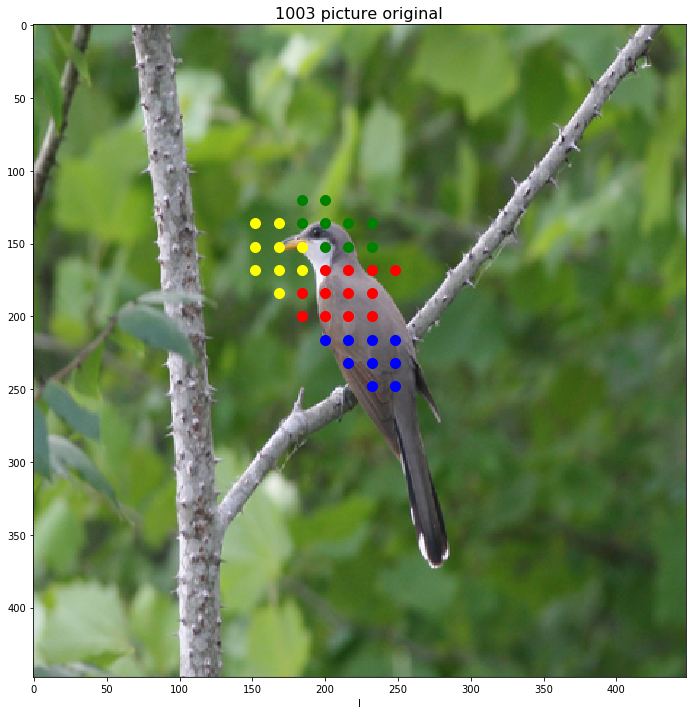

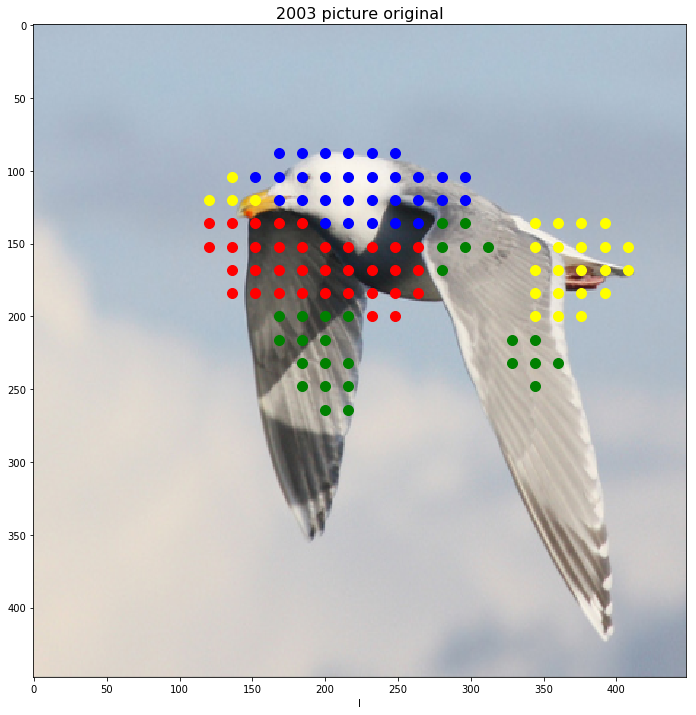

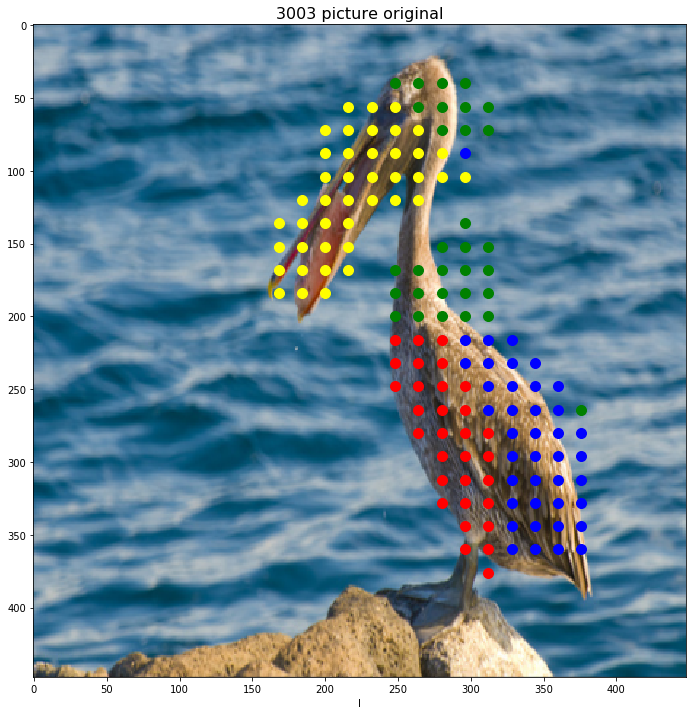

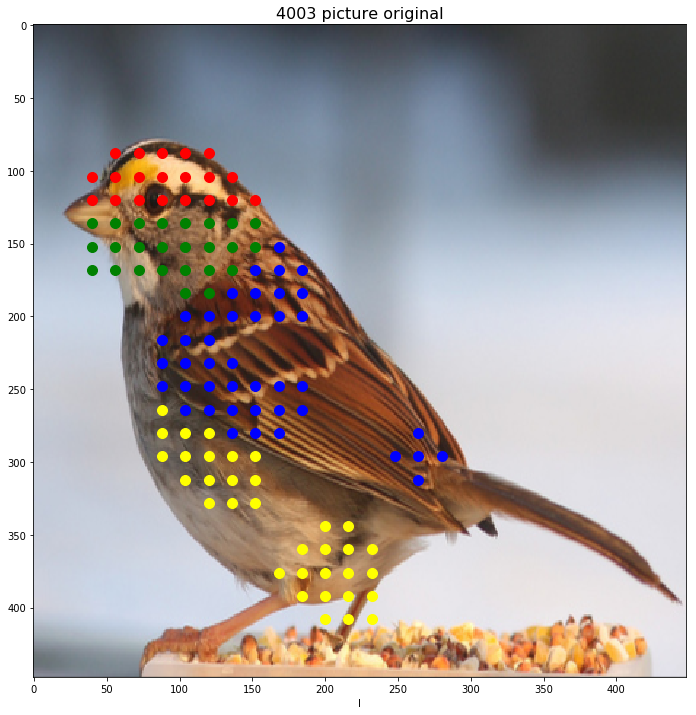

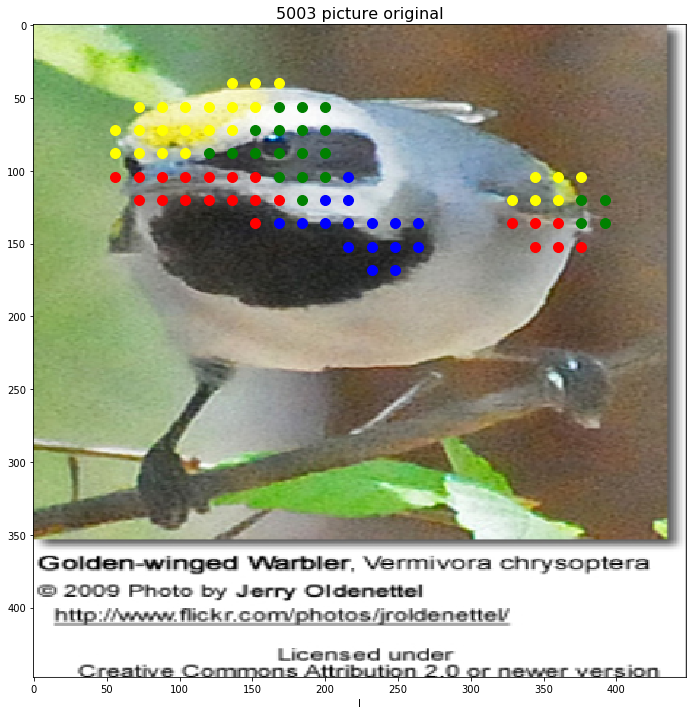

In [10]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import time

env = lmdb.open("/home/lvlab/Pytorch/feature_train_bird")
txn = env.begin()

x_p = np.zeros((512, 30, 30))
cls_vec_p = np.zeros((5994, 4))
par_vec_p = np.zeros((5994, 4))
par_max_p = np.zeros((5994, 4))
par_train_vector_list = []
par_regions = np.zeros((5994, 8)) 

for ii in range(5994):
    if (ii - 3) % 1000 == 0:
        print(ii)
        vectors = train_vectors[ii]
        key = '{:0>10d}'.format(ii)
        x = np.frombuffer(txn.get(key.encode()), dtype=np.float32).reshape(512, 28, 28)
        x_p[:, 1:29, 1:29] = x
        N = vectors.shape[0]
        print("N = ", N)

        sim_mat = np.zeros((N, N))
        A = np.zeros((512, 3, 3))
        B = np.zeros((512, 3, 3))
        for i in range(N):
            core_x, core_y = int(vectors[i, 0]), int(vectors[i, 1])
            A = x_p[:, core_x:core_x + 3, core_y:core_y + 3]
            for j in range(N):
                core_x, core_y = int(vectors[j, 0]), int(vectors[j, 1])
                B = x_p[:, core_x:core_x + 3, core_y:core_y + 3]
                sim = np.sum(A * B)/(np.sqrt(np.sum(A**2)) * np.sqrt(np.sum(B**2)))
                sim_mat[i, j] = sim

        k1, k2 = 4, 4

        for i in range(N):
            sim_mat[i, i] = 0
        Dn = np.diag(np.power(np.sum(sim_mat, axis=1), -0.5))
        L = np.eye(N) - np.dot(np.dot(Dn, sim_mat), Dn)
        eigvals, eigvecs = np.linalg.eig(L)
        indices = np.argsort(eigvals)[:k1]
        subvecs = normalize(eigvecs[:, indices])
        cls_lab = KMeans(n_clusters=k2).fit_predict(subvecs)


        cls_points = np.zeros((k2, 2))
        cls_weight = np.zeros(k2)
        cls_list = [[] for i in range(k2)]

        for i in range(k2):
            num = 0
            for j in range(N):
                if cls_lab[j] == i:
                    num += 1
                    cls_list[i].append(j)
                    cls_weight[i] += vectors[j, 2]
                    cls_points[i, 0] += vectors[j, 0]
                    cls_points[i, 1] += vectors[j, 1]
            cls_points[i, 0] = cls_points[i, 0]/num
            cls_points[i, 1] = cls_points[i, 1]/num
            cls_weight[i] = cls_weight[i]/num

        # ***********************************************************************************************  
        line = train_list[ii]
        img_dir_label = line.strip('\n').split(' ')
        img_dir = os.path.join(root_dir, img_dir_label[0])
        image = io.imread(img_dir)
        if len(image.shape) == 2:
            image = image[:,:,np.newaxis]
            image = np.tile(image, [1, 1, 3])

        image = skimage.util.img_as_ubyte(transform.resize(image, (448, 448)))

        pyplot.figure(figsize=(12, 12))
        ax = pyplot.subplot(1, 1, 1)


        for i in range(N):
            if cls_lab[i] == 0:
                ax.scatter(vectors[i, 1] * 16 + 8, vectors[i, 0] * 16 + 8, \
                           c = 'yellow', marker='o', s=100, alpha=1)
            elif cls_lab[i] == 1:
                ax.scatter(vectors[i, 1] * 16 + 8, vectors[i, 0] * 16 + 8, \
                           c = 'green', marker='o', s=100, alpha=1)
            elif cls_lab[i] == 2:
                ax.scatter(vectors[i, 1] * 16 + 8, vectors[i, 0] * 16 + 8, \
                           c = 'blue', marker='o', s=100, alpha=1)
            else:
                ax.scatter(vectors[i, 1] * 16 + 8, vectors[i, 0] * 16 + 8, \
                           c = 'red', marker='o', s=100, alpha=1)

        pyplot.imshow(image)
        pyplot.axis('on')
        pyplot.xlabel('l')
        pyplot.title('%d picture original' % ii, fontsize=16)
    
print("complete")
txn.commit()
env.close()

4
1004


/home/lvlab/.tensorflow_pytorch/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/lvlab/.tensorflow_pytorch/lib/python3.5/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


2004
3004
4004
5004
complete


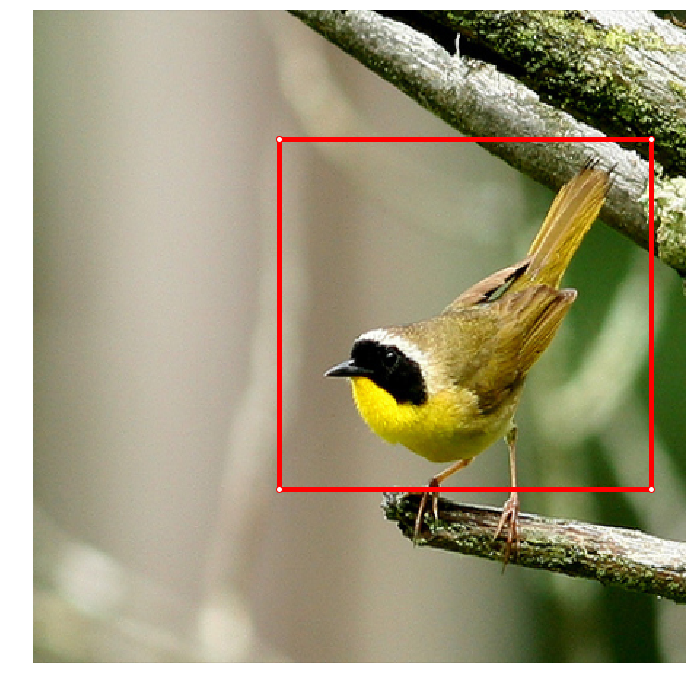

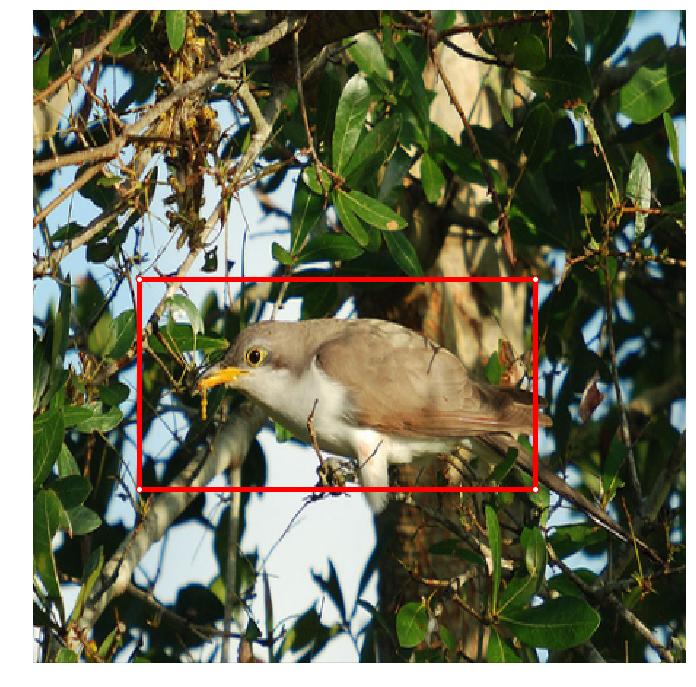

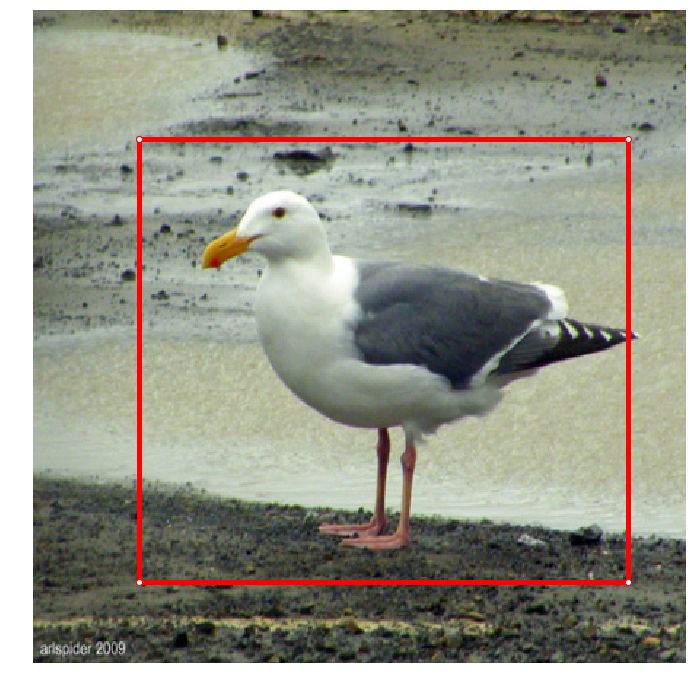

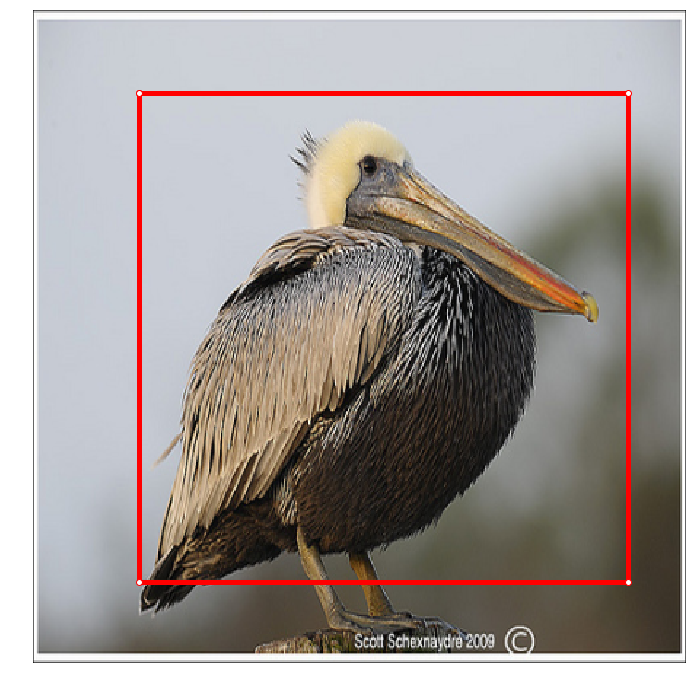

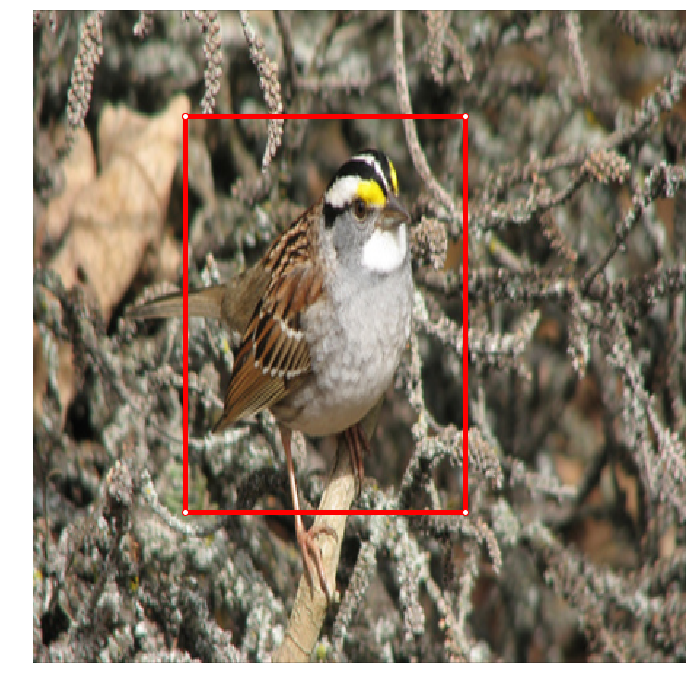

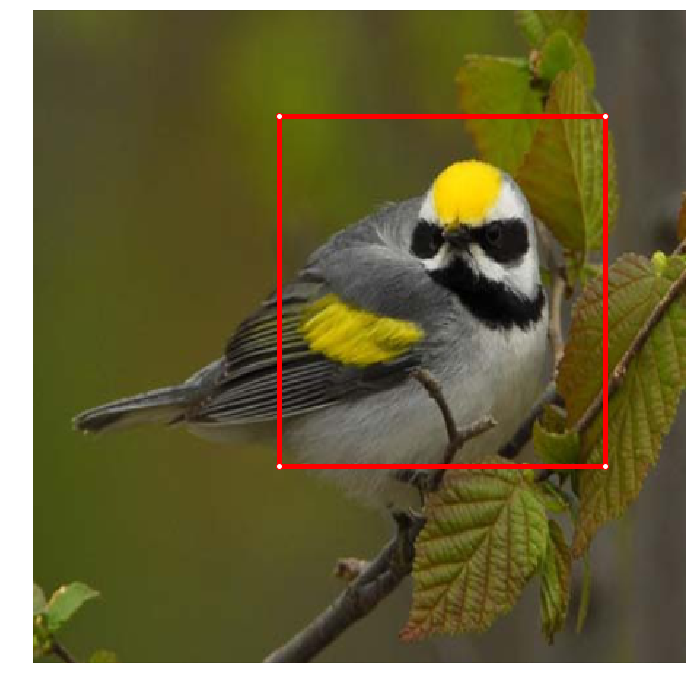

In [9]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import lmdb
import time

env = lmdb.open("/home/lvlab/Pytorch/feature_train_bird")
txn = env.begin()

x_p = np.zeros((512, 30, 30))

for ii in range(5994):
    if (ii - 4) % 1000 == 0:
        print(ii)
        vectors = train_vectors[ii]
            
        # ****************************************************************************************************
        edge = 32
        x1, x2, y1, y2 = np.min(vectors[:, 0]), np.max(vectors[:, 0]), \
                        np.min(vectors[:, 1]), np.max(vectors[:, 1])
        
        x1, x2, y1, y2 = np.maximum(x1 * 16 + 8 - edge, 0), np.minimum(x2 * 16 + 8 + edge, 448), \
                        np.maximum(y1 * 16 + 8 - edge, 0), np.minimum(y2 * 16 + 8 + edge, 448)
        Xp, Yp = np.array([x1, x2, x2, x1, x1]), np.array([y1, y1, y2, y2, y1])
        
        pyplot.figure(figsize=(12, 12))
        ax = pyplot.subplot(1, 1, 1)
        ax.plot(Yp, Xp, marker='o', c='red', linewidth = 5, linestyle='solid', markerfacecolor='white', \
               label = 'points')
        
        line = train_list[ii]
        img_dir_label = line.strip('\n').split(' ')
        img_dir = os.path.join(root_dir, img_dir_label[0])
        image = io.imread(img_dir)
        if len(image.shape) == 2:
            image = image[:,:,np.newaxis]
            image = np.tile(image, [1, 1, 3])

        image = skimage.util.img_as_ubyte(transform.resize(image, (448, 448), mode='constant'))

        pyplot.imshow(image)
        pyplot.axis('off')
    
print("complete")
txn.commit()
env.close()

4


/home/lvlab/.tensorflow_pytorch/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/lvlab/.tensorflow_pytorch/lib/python3.5/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


1004
2004
3004
4004
5004
complete


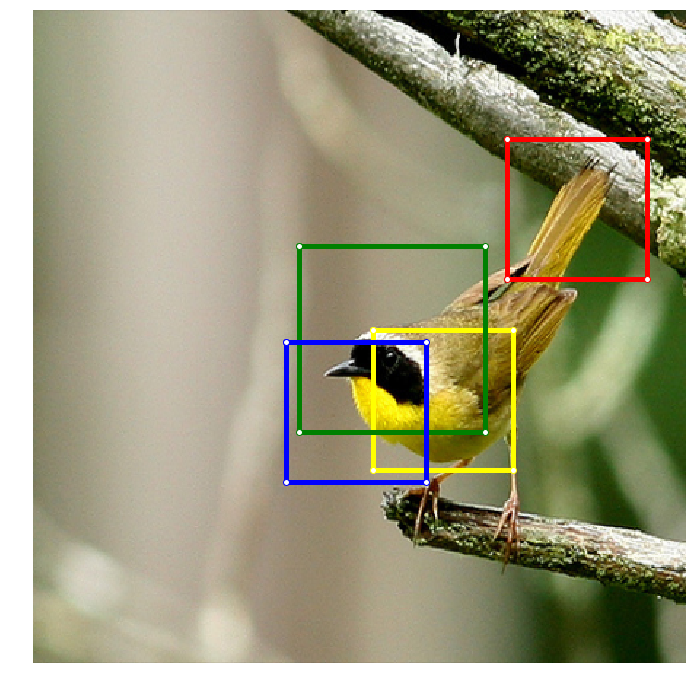

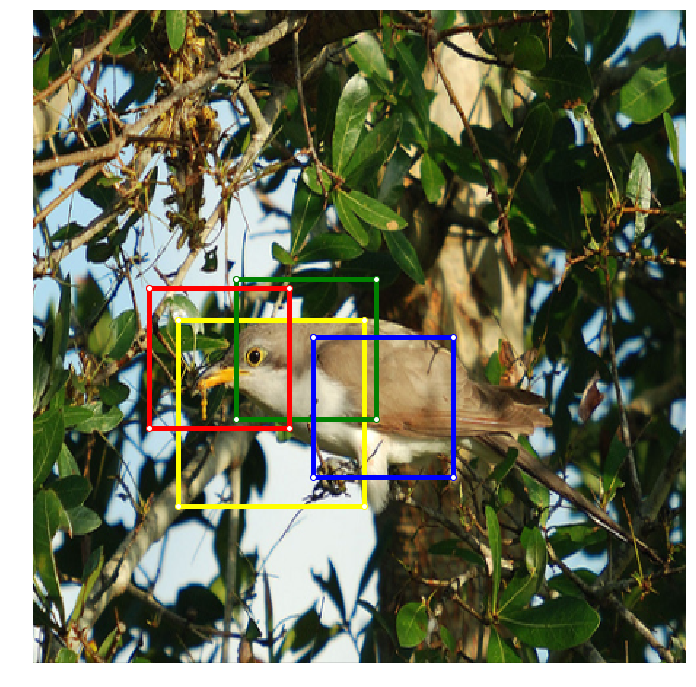

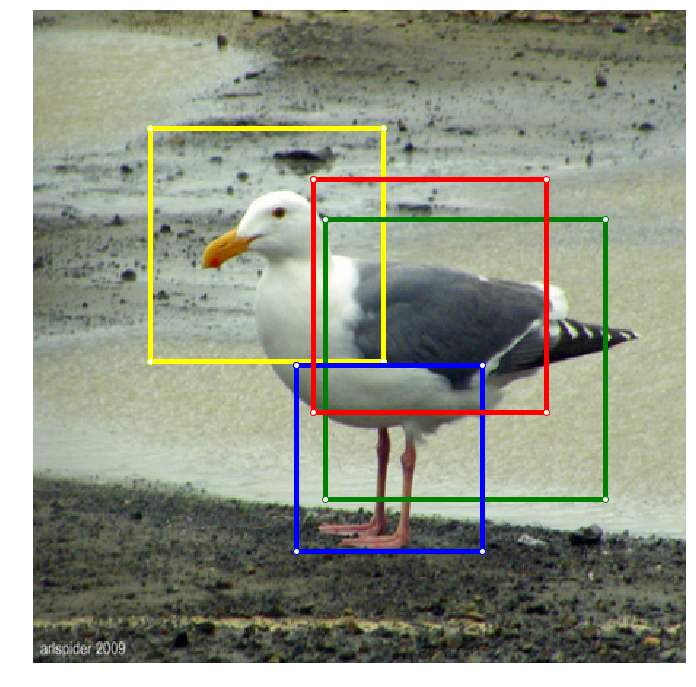

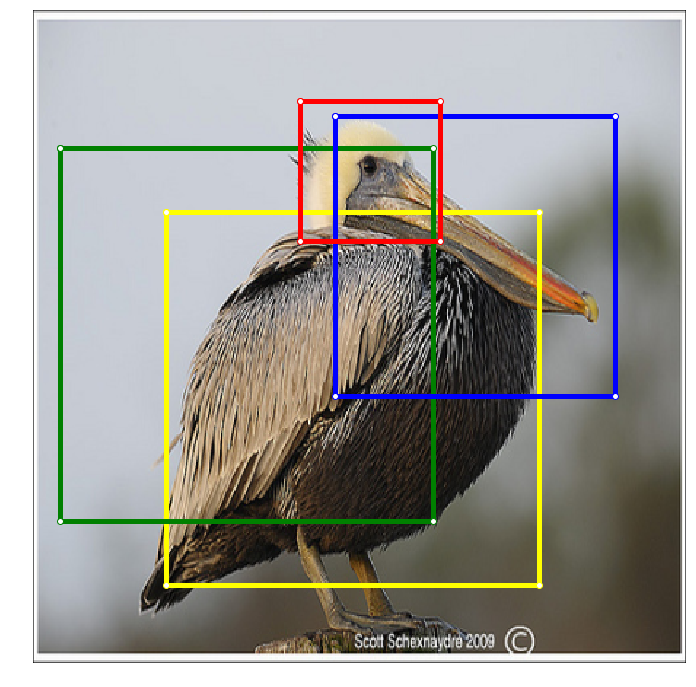

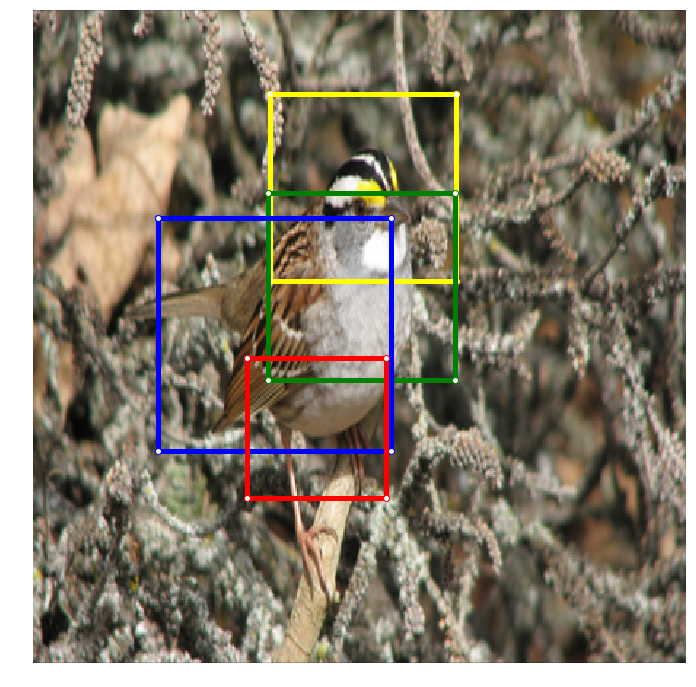

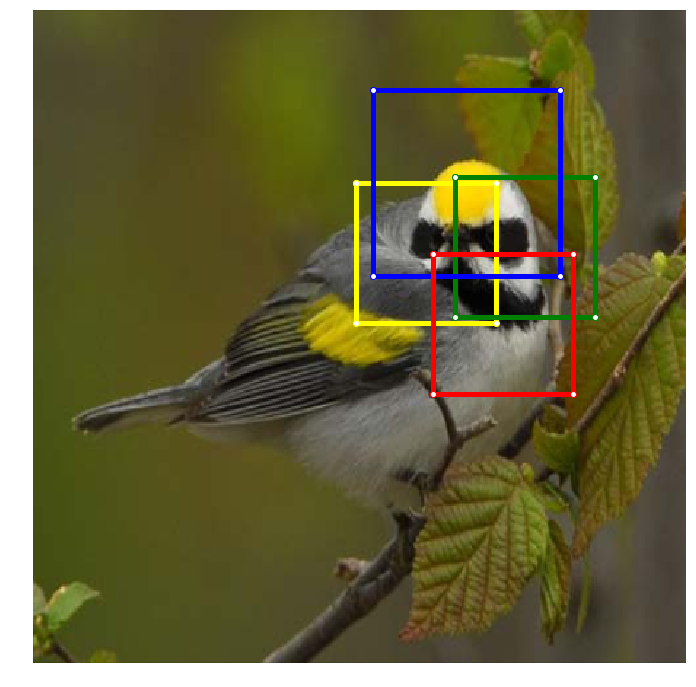

In [7]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import time

env = lmdb.open("/home/lvlab/Pytorch/feature_train_bird")
txn = env.begin()

x_p = np.zeros((512, 30, 30))

for ii in range(5994):
    if (ii - 4) % 1000 == 0:
        print(ii)
        vectors = train_vectors[ii]
        key = '{:0>10d}'.format(ii)
        x = np.frombuffer(txn.get(key.encode()), dtype=np.float32).reshape(512, 28, 28)
        x_p[:, 1:29, 1:29] = x
        N = vectors.shape[0]
        sim_mat = np.zeros((N, N))
        A = np.zeros((512, 3, 3))
        B = np.zeros((512, 3, 3))
        for i in range(N):
            core_x, core_y = int(vectors[i, 0]), int(vectors[i, 1])
            A = x_p[:, core_x:core_x + 3, core_y:core_y + 3]
            for j in range(N):
                core_x, core_y = int(vectors[j, 0]), int(vectors[j, 1])
                B = x_p[:, core_x:core_x + 3, core_y:core_y + 3]
                sim = np.sum(A * B)/(np.sqrt(np.sum(A**2)) * np.sqrt(np.sum(B**2)))
                sim_mat[i, j] = sim

        k1, k2 = 4, 4

        for i in range(N):
            sim_mat[i, i] = 0
        Dn = np.diag(np.power(np.sum(sim_mat, axis=1), -0.5))
        L = np.eye(N) - np.dot(np.dot(Dn, sim_mat), Dn)
        eigvals, eigvecs = np.linalg.eig(L)
        indices = np.argsort(eigvals)[:k1]
        subvecs = normalize(eigvecs[:, indices])
        cls_lab = KMeans(n_clusters=k2).fit_predict(subvecs)


        cls_points = np.zeros((k2, 2))
        cls_weight = np.zeros(k2)
        cls_list = [[] for i in range(k2)]

        for i in range(k2):
            num = 0
            for j in range(N):
                if cls_lab[j] == i:
                    num += 1
                    cls_list[i].append(j)
                    cls_weight[i] += vectors[j, 2]
                    cls_points[i, 0] += vectors[j, 0]
                    cls_points[i, 1] += vectors[j, 1]
            cls_points[i, 0] = cls_points[i, 0]/num
            cls_points[i, 1] = cls_points[i, 1]/num
            cls_weight[i] = cls_weight[i]/num
     
        par_vec_list = []
        for i in range(k2):
            cls_num = len(cls_list[i])
            par_vec = np.zeros((cls_num, 4))
            for j in range(cls_num):
                par_vec[j, :] = np.array([vectors[cls_list[i][j], 0], vectors[cls_list[i][j], 1], \
                                         vectors[cls_list[i][j], 2], vectors[cls_list[i][j], 2]])
            par_vec[:, 3] = par_vec[:, 3]/np.sum(par_vec[:, 3])
            
            par_vec_list.append(par_vec)
            
        vectors_list = np.array(par_vec_list)
        # *****************************************************************************************************
        new_vectors = []
        for i in range(k1):
            vectors_part = vectors_list[i]
            if isinstance(vectors_part, list):
                vectors_part = np.array(vectors_part)
            num_p = vectors_part.shape[0]
            cls_p = 0
            lists = []
            lab_set = {i for i in range(num_p)}
            while(cls_p < num_p):
                cls_l = []
                start = lab_set.pop()
                cls_l.append(start)
                cls_p += 1
                cls_new_p = True
                while(cls_new_p):
                    rm_l = []
                    cls_new_p = False
                    for k in lab_set:
                        new_p = False
                        for t in range(len(cls_l)):
                            dis = np.sum(pow(vectors_part[k, 0:2] - vectors_part[cls_l[t], 0:2], 2)) 
                            if dis <= 2:
                                new_p = True
                                break
                        if new_p:
                            cls_new_p = True
                            rm_l.append(k)
                            cls_l.append(k)
                            cls_p += 1

                    for kk in range(len(rm_l)):
                        lab_set.remove(rm_l[kk])
                lists.append(cls_l)

            l_n = [len(lists[i]) for i in range(len(lists))]
            new_vector_index = lists[int(l_n.index(max(l_n)))]
            new_vector = np.zeros((max(l_n), 4))
            for i in range(max(l_n)):
                new_vector[i] = vectors_part[new_vector_index[i]]
            new_vectors.append(new_vector)
            
        new_vectors = np.array(new_vectors)
        
        pyplot.figure(figsize=(12, 12))
        ax = pyplot.subplot(1, 1, 1)
#         # ***********************************************************************************************  
        color_list = ['yellow', 'green', 'blue', 'red']
        for i in range(4):
            part_vector = new_vectors[i]

            part_x, part_y = np.round(np.sum(part_vector[:, 0])/part_vector.shape[0] * 16 + 8), \
                            np.round(np.sum(part_vector[:, 1])/part_vector.shape[0] * 16 + 8)
            
            l_d = np.maximum((np.max(part_vector[:, 0]) - np.min(part_vector[:, 0])), \
                            (np.max(part_vector[:, 1]) - np.min(part_vector[:, 1])))
            if l_d <= 4:
                l = 48
            elif 4 < l_d <= 6:
                l = 64
            elif 6 < l_d <= 8:
                l = 80
            elif 8 < l_d <= 10:
                l = 96
            elif 10 < l_d <= 12:
                l = 112
            elif 12 < l_d <= 14:
                l = 128
            else:
                l = 144
                
            m1, m2, n1, n2 = int(np.maximum(0, part_x - l)), int(np.minimum(448, part_x + l)), \
                            int(np.maximum(0, part_y - l)), int(np.minimum(448, part_y + l))
            
            Xp, Yp = np.array([n1, n2, n2, n1, n1]), np.array([m1, m1, m2, m2, m1])
            ax.plot(Xp, Yp, marker='o', c=color_list[i], linewidth = 5, linestyle='solid', markerfacecolor='white', \
               label = 'points')
        
        line = train_list[ii]
        img_dir_label = line.strip('\n').split(' ')
        img_dir = os.path.join(root_dir, img_dir_label[0])
        image = io.imread(img_dir)
        if len(image.shape) == 2:
            image = image[:,:,np.newaxis]
            image = np.tile(image, [1, 1, 3])

        image = skimage.util.img_as_ubyte(transform.resize(image, (448, 448), mode='constant'))

        pyplot.imshow(image)
        pyplot.axis('off')
    
print("complete")
txn.commit()
env.close()